<a href="https://colab.research.google.com/github/daniellechowicz/innoradar/blob/main/VGG16_InnoRadar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Appendix A
## Wood scanning: a technology for the few?
### What is a wood scanner and how does it work?
#### A short tutorial on how to prepare a machine learning model

First of all, it is necessary to upload images. The images are located on my Google Drive, and they are structured as follows: 

In [2]:
!sudo apt install tree

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tree is already the newest version (1.7.0-5).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [3]:
!tree ./drive/MyDrive/data -d

./drive/MyDrive/data
├── test
│   ├── flawless
│   └── knot
├── train
│   ├── flawless
│   └── knot
└── validate
    ├── flawless
    └── knot

9 directories


To make things faster, the images need to be copied to the local filesystem:

In [4]:
from google.colab import drive

drive.mount('/content/drive')
!cp -r "/content/drive/My Drive/data" ./img

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Once the images have been copied to the local filesystem, let's have a look what they contain:

In [5]:
import numpy as np
from PIL import Image, ImageDraw, ImageFont, ImageOps

examples = [10, 15, 30, 40, 50]
size = (224, 224)
rectangle_color = "purple"
font = ImageFont.load_default()

1. Flawless

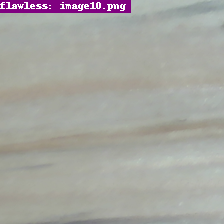

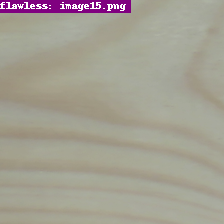

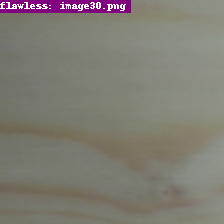

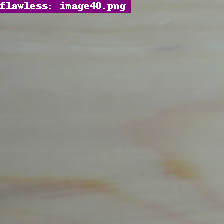

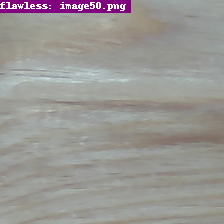

In [6]:
for i in examples:
  image = Image.open('/content/img/validate/flawless/image{}.png'.format(i))
  image = ImageOps.fit(image, size, Image.ANTIALIAS)
  draw = ImageDraw.Draw(image)
  draw.rectangle((0, 0, 0 + 130, 0 + 12), fill=rectangle_color)
  draw.text((0, 0), "flawless: image{}.png".format(i), (255, 255, 255), font=font)
  display(image)

2. Knots

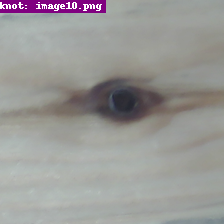

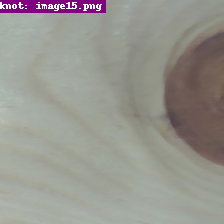

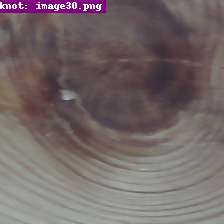

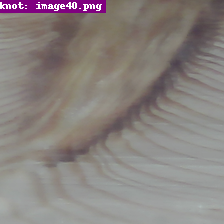

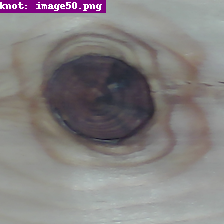

In [7]:
for i in examples:
  image = Image.open('/content/img/validate/knot/image{}.png'.format(i))
  image = ImageOps.fit(image, size, Image.ANTIALIAS)
  draw = ImageDraw.Draw(image)
  draw.rectangle((0, 0, 0 + 105, 0 + 12), fill=rectangle_color)
  draw.text((0, 0), "knot: image{}.png".format(i), (255, 255, 255), font=font)
  display(image)

Now, we need to install a library which is going to be our main building block for this project. ***TensorFlow*** is an end-to-end open source machine learning platform.

In [8]:
!pip install tensorflow==1.15

In [9]:
import tensorflow as tf

To avoid wandering in the dark with architecture selection, we will use the architecture from the publication specified down below. It has been proven to be good enough, also let's give it a try.

*Chollet, Francois. (2017). Xception: Deep Learning with Depthwise Separable Convolutions. 1800-1807. 10.1109/CVPR.2017.195.*

In [10]:
conv_base = tf.keras.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224, 224, 3),
    pooling=None,
)
# Before we compile and train the model, we need to freeze the convolutional base.
conv_base.trainable = False
conv_base.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
__________

In [11]:
model = tf.keras.models.Sequential()
model.add(conv_base)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 7, 7, 2048)        20861480  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               25690368  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 46,552,105
Trainable params: 25,690,625
Non-trainable params: 20,861,480
_________________________________________________________________


In [12]:
model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=2e-5),
    metrics=['acc']
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = '/content/img/train'
validation_dir = '/content/img/test'

train_datagen = ImageDataGenerator(
    rescale=1./255,
)

test_datagen = ImageDataGenerator(rescale=1./255) # Validation data cannot be modified.

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=20,
    class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=20,
    class_mode='binary'
)

Found 2500 images belonging to 2 classes.
Found 1240 images belonging to 2 classes.


In [14]:
history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=5,
    validation_data=validation_generator,
    validation_steps=50,
    verbose=1
)

Epoch 1/5
100/100 [==============================] - 41s 411ms/step - loss: 0.1957 - acc: 0.9305 - val_loss: 0.9122 - val_acc: 0.5730
Epoch 2/5
100/100 [==============================] - 35s 348ms/step - loss: 0.1013 - acc: 0.9685 - val_loss: 0.6548 - val_acc: 0.7000
Epoch 3/5
100/100 [==============================] - 35s 351ms/step - loss: 0.0659 - acc: 0.9790 - val_loss: 0.4741 - val_acc: 0.8180
Epoch 4/5
100/100 [==============================] - 36s 355ms/step - loss: 0.0453 - acc: 0.9835 - val_loss: 0.9297 - val_acc: 0.6610
Epoch 5/5
100/100 [==============================] - 35s 353ms/step - loss: 0.0499 - acc: 0.9830 - val_loss: 0.4751 - val_acc: 0.8260


Let's verify how accurate the model is.

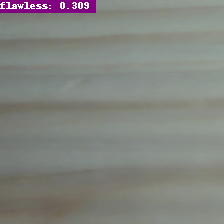

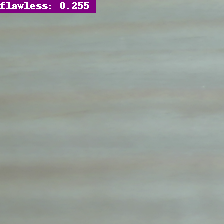

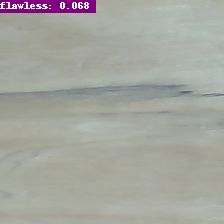

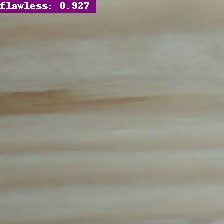

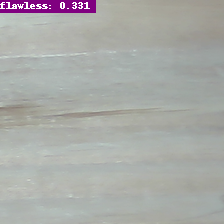

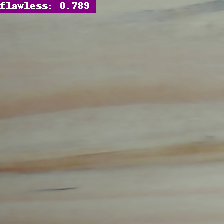

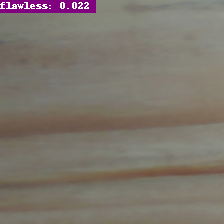

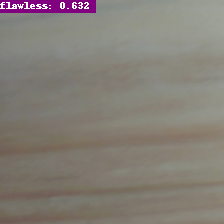

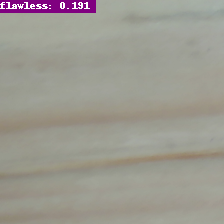

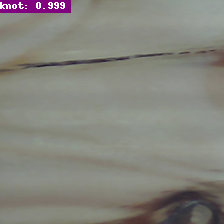

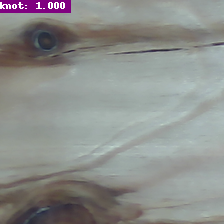

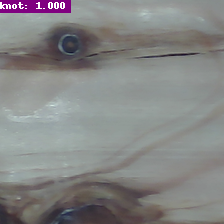

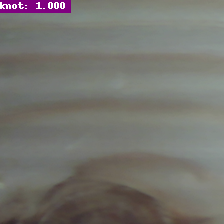

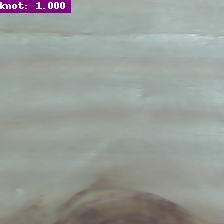

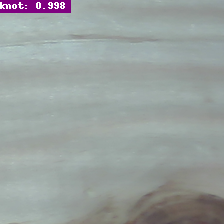

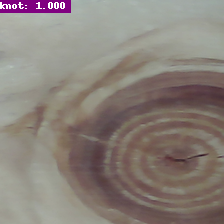

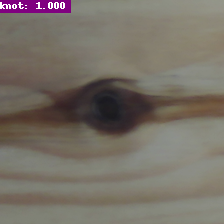

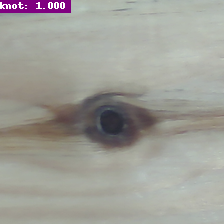

In [25]:
for variant in ['flawless', 'knot']:
  for i in range(1, 10):
    image = Image.open('/content/img/validate/{}/image{}.png'.format(variant, i))
    image = ImageOps.fit(image, size, Image.ANTIALIAS)
    image_array = np.asarray(image)
    normalized_image_array = (image_array.astype(np.float32) / 127.0) - 1
    data = np.ndarray(shape=(1, 224, 224, 3), dtype=np.float32)
    data[0] = normalized_image_array
    prediction = model.predict(data)
    prediction = prediction[0][0]
    font = ImageFont.load_default()
    draw = ImageDraw.Draw(image)
    if variant == "flawless":
      draw.rectangle((0, 0, 0 + 95, 0 + 12), fill=rectangle_color)
    else:
      draw.rectangle((0, 0, 0 + 70, 0 + 12), fill=rectangle_color)
    draw.text((0, 0), f"{variant}: {prediction:.3f}", (255, 255, 255), font=font)
    display(image)

In [ ]:
model.save('/content/drive/My Drive/xception_model.h5')